In [ ]:
# ============================================================================
# # MODULE 4: NAMED ENTITY RECOGNITION WITH TRANSFORMERS
# ====================================================
# 
# Project: Two-stage multilingual NER project with mBERT
# 
# STAGE 1 (current notebook): English baseline with CoNLL-2003
# - Compare BiLSTM (M3) vs mBERT (M4) on gold standard dataset
# - Demonstrate mBERT's multilingual pre-training benefits on single language
# - Establish performance benchmark for transformer architecture
# 
# STAGE 2 (M4_MNER_multilingual.ipynb): Cross-lingual extension
# - German, French, Dutch with WikiANN dataset
# - Multilingual training and cross-lingual transfer evaluation
# - Note: CoNLL-2003 German unavailable due to copyright restrictions
# 
# Model: mBERT (bert-base-multilingual-cased)
# - Pre-trained on 104 languages (Wikipedia + BookCorpus)
# - 177M parameters, 12 layers, 768 hidden size
# - Even for English-only fine-tuning, benefits from cross-lingual knowledge
# 
# Learning objectives:
# - Understand Transformer architecture for token classification
# - Compare sequential (BiLSTM) vs attention-based (Transformer) approaches
# - Evaluate multilingual pre-training benefits on monolingual task
# - Establish baseline for multilingual extension (Stage 2)
# ============================================================================

# Cell 1 - Library Imports and Environment Setup

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter  # For entity distribution analysis
import warnings
warnings.filterwarnings('ignore')  # Comment out if you want to see warnings

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Hugging Face Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)

# Evaluation metrics
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score
)

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    
print("\n✓ All libraries imported successfully")




Using device: cpu

✓ All libraries imported successfully


## Library Imports and Environment Setup

### Libraries Imported

**Core Scientific Libraries**
- `numpy`, `pandas`: Data manipulation and numerical operations
- `matplotlib`, `seaborn`: Visualization
- `Counter`: Entity distribution analysis across languages

**PyTorch Framework**
- `torch`, `torch.nn`: Deep learning framework (same as Module 2)
- `DataLoader`, `Dataset`: Batch processing

**HuggingFace Transformers**
- `AutoTokenizer`: Automatically loads the correct tokenizer
- `AutoModelForTokenClassification`: Pre-trained Transformer for token classification (NER)
- `TrainingArguments`, `Trainer`: High-level training API (automated training loop)
- `DataCollatorForTokenClassification`: Handles padding and batching for NER

**Evaluation Metrics**
- `seqeval`: Specialized for sequence labeling evaluation
- Evaluates at entity level (not token level like sklearn)
- Returns F1, precision, recall per entity type (PER, LOC, ORG, MISC)

### Comparison with Module 3

**Module 3** ([GitHub: nlp-m3-NER-news](https://github.com/olgaanna75/nlp-m3-NER-news))
- Framework: TensorFlow/Keras
- Architecture: BiLSTM for NER on CoNLL-2003 English
- Training: Manual loops
- Metrics: sklearn (token-level)

**Module 4** (current notebook)
- Framework: PyTorch
- Architecture: Transformer (mBERT/XLM-RoBERTa) for multilingual NER
- Training: `Trainer` API (automated)
- Metrics: `seqeval` (entity-level, more rigorous)

### Configuration

**Reproducibility**: Random seed = 42 for consistent results across runs

**Device**: CPU (code automatically uses GPU if available)

### Technical Note

`tf-keras` was installed to resolve a Keras 3 compatibility issue with the `transformers` library. This does not affect the workflow - all code uses PyTorch exclusively.

### Expected Output
```
Using device: cpu
✓ All libraries imported successfully
```

In [ ]:
# Cell 2 - Load CoNLL-2003 English Dataset
# Manual loading approach (same as Module 3)
# Note: Multilingual extension (DE/FR/NL) available in separate notebook (M4_MNER_multilingual.ipynb)
# using WikiANN dataset due to CoNLL-2003 German copyright restrictions

import os

def load_conll2003_file(filepath):
    # Parse CoNLL-2003 format and return DataFrame with corrected BIO tags
    sentences = []
    sentence_tokens = []
    sentence_labels = []
    
    current_tokens = []
    current_labels = []
    
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            
            if line.startswith('-DOCSTART-'):  # Skip document boundaries
                continue
            
            if line == '':  # End of sentence (blank line)
                if current_tokens:
                    sentences.append(' '.join(current_tokens))
                    sentence_tokens.append(current_tokens.copy())
                    sentence_labels.append(current_labels.copy())
                    current_tokens = []
                    current_labels = []
            else:
                parts = line.split()  # Format: word pos chunk ner_tag
                if len(parts) >= 4:
                    token = parts[0]
                    ner_tag = parts[3]
                    current_tokens.append(token)
                    current_labels.append(ner_tag)
    
    if current_tokens:
        sentences.append(' '.join(current_tokens))
        sentence_tokens.append(current_tokens)
        sentence_labels.append(current_labels)
    
    # FIX: Convert I-tags to B-tags where appropriate (IOB1 → IOB2)
    for i in range(len(sentence_labels)):
        labels = sentence_labels[i]
        fixed_labels = []
        
        for j, label in enumerate(labels):
            if label.startswith('I-'):
                entity_type = label[2:]  # Extract PER, LOC, ORG, MISC
                
                # Convert I→B if: start of sentence OR after O OR different entity type
                if j == 0:  # Start of sentence
                    fixed_labels.append('B-' + entity_type)
                elif labels[j-1] == 'O':  # After non-entity
                    fixed_labels.append('B-' + entity_type)
                elif not labels[j-1].endswith(entity_type):  # Different entity type
                    fixed_labels.append('B-' + entity_type)
                else:  # Continuation of same entity
                    fixed_labels.append(label)
            else:
                fixed_labels.append(label)
        
        sentence_labels[i] = fixed_labels
    
    return pd.DataFrame({
        'sentence': sentences,
        'tokens': sentence_tokens,
        'labels': sentence_labels
    })


# Load English dataset
print("="*70)
print("LOADING CoNLL-2003 ENGLISH DATASET")
print("="*70)

# Define data paths
data_dir = os.path.join('..', 'data', 'raw', 'en')
train_path = os.path.join(data_dir, 'train.txt')
valid_path = os.path.join(data_dir, 'valid.txt')
test_path = os.path.join(data_dir, 'test.txt')

# Load datasets
print("\nLoading dataset...")
train_df = load_conll2003_file(train_path)
val_df = load_conll2003_file(valid_path)
test_df = load_conll2003_file(test_path)

# Display dataset info
print(f"\n✓ English dataset loaded successfully\n")
print(f"Dataset sizes:")
print(f"  Training:   {len(train_df):>6,} sentences")
print(f"  Validation: {len(val_df):>6,} sentences")
print(f"  Test:       {len(test_df):>6,} sentences")
print(f"  Total:      {len(train_df) + len(val_df) + len(test_df):>6,} sentences")

# Extract and display unique labels
all_labels = set()
for labels in train_df['labels']:
    all_labels.update(labels)

label_names = sorted(list(all_labels))

print(f"\nNER labels ({len(label_names)} types):")
for i, label in enumerate(label_names):
    print(f"  {i}: {label}")

# Display sample
print("\n" + "="*70)
print("Sample sentence from training set:")
print("-"*70)
print(f"Tokens: {train_df.iloc[0]['tokens'][:15]}")
print(f"Labels: {train_df.iloc[0]['labels'][:15]}")
print("="*70)

LOADING CoNLL-2003 ENGLISH DATASET

Loading datasets...

✓ English dataset loaded successfully

Dataset sizes:
  Training:   14,041 sentences
  Validation:  3,250 sentences
  Test:        3,453 sentences
  Total:      20,744 sentences

NER labels (9 types):
  0: B-LOC
  1: B-MISC
  2: B-ORG
  3: B-PER
  4: I-LOC
  5: I-MISC
  6: I-ORG
  7: I-PER
  8: O

Sample sentence from training set:
----------------------------------------------------------------------
Tokens: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
Labels: ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


## Data Loading Approach

### Manual File Parsing

CoNLL-2003 files are loaded using manual parsing (same approach as Module 3). This became necessary after HuggingFace's `load_dataset("conll2003")` was deprecated due to security concerns with executable dataset scripts.

**File format**: CoNLL-2003 uses space-separated columns:
```
word    pos    chunk    ner_tag
EU      NNP    B-NP     B-ORG
rejects VBZ    B-VP     O
```

The parser:
- Reads line by line
- Skips document boundaries (`-DOCSTART-`)
- Splits sentences on blank lines
- Extracts tokens and NER tags

### Data Quality Issue: IOB Format Inconsistency

**Problem discovered**: The original CoNLL-2003 files contain inconsistent BIO tagging across entity types.

**IOB1 vs IOB2 formats**:
- **IOB1** (older): I-tag can mark both beginning OR continuation of entity
- **IOB2** (current standard): B-tag explicitly marks beginning, I-tag only marks continuation

**Inconsistency in CoNLL-2003**:
- **LOC, ORG, MISC**: Properly tagged with B- and I- tags (IOB2 format)
- **PER**: Only I-tags present, no B-tags (IOB1 format)

**Example from source files** (before correction):
```
Tokens: ['Peter', 'Blackburn']
Labels: ['I-PER', 'I-PER']
```
Both tokens marked "Inside" - impossible to determine where the entity begins.

**Why this matters**:

Entity-level evaluation metrics (seqeval) count entities by identifying B-tags. Without B-PER tags, person entities cannot be properly detected or counted. The inconsistency likely stems from the original 2003 annotation process or an incomplete format conversion.

**Why undetected in Module 3**:

Module 3 used sklearn metrics with token-level evaluation:
- Both B-PER and I-PER map to class "PER"  
- Metrics calculated per token, not per entity
- Data inconsistency masked by evaluation approach

Module 4 uses seqeval with entity-level evaluation:
- Requires proper B-tags to identify and count entities
- Stricter evaluation aligned with NER task definition
- Immediately reveals missing B-PER tags

### Correction Applied

The `load_conll2003_file()` function includes **in-memory correction** during data loading:

**Conversion rule** (IOB1 → IOB2):
An I-tag is converted to B-tag when:
- Token is at sentence start, OR
- Previous token is 'O' (outside any entity), OR  
- Previous token belongs to different entity type

Otherwise I-tag is preserved as valid continuation.

**Example** (after correction):
```
Before: ['I-PER', 'I-PER', 'O', 'I-LOC']
After:  ['B-PER', 'I-PER', 'O', 'B-LOC']
```

**Implementation approach**:
- Original files remain unchanged on disk
- Correction applied automatically when Cell 2 executes
- Transformation explicit and documented in code
- Ensures consistent IOB2 tagging across all entity types

This correction is essential for Module 4, as mBERT training and evaluation rely on proper entity boundary detection.

In [3]:
# Cell 3 - Data Exploration
# Analyze entity distribution and dataset characteristics

# Display detailed statistics
print("="*70)
print("DATA EXPLORATION - CoNLL-2003 ENGLISH")
print("="*70)

# Count total tokens
total_tokens_train = sum(len(tokens) for tokens in train_df['tokens'])
total_tokens_val = sum(len(tokens) for tokens in val_df['tokens'])
total_tokens_test = sum(len(tokens) for tokens in test_df['tokens'])

print(f"\nToken counts:")
print(f"  Training:   {total_tokens_train:>8,} tokens")
print(f"  Validation: {total_tokens_val:>8,} tokens")
print(f"  Test:       {total_tokens_test:>8,} tokens")
print(f"  Total:      {total_tokens_train + total_tokens_val + total_tokens_test:>8,} tokens")

# Average sentence length
avg_len_train = total_tokens_train / len(train_df)
avg_len_val = total_tokens_val / len(val_df)
avg_len_test = total_tokens_test / len(test_df)

print(f"\nAverage sentence length:")
print(f"  Training:   {avg_len_train:.1f} tokens/sentence")
print(f"  Validation: {avg_len_val:.1f} tokens/sentence")
print(f"  Test:       {avg_len_test:.1f} tokens/sentence")

# Count entities by type
def count_entities(df):
    # Count entities by type (B-tags = beginning of entity)
    from collections import Counter
    
    entity_counts = Counter()
    total_entities = 0
    
    for labels in df['labels']:
        for label in labels:
            if label.startswith('B-'):  # Count only B-tags
                entity_counts[label] += 1
                total_entities += 1
    
    return dict(entity_counts), total_entities

print("\n" + "="*70)
print("ENTITY DISTRIBUTION")
print("="*70)

# Count for each split
train_entities, train_total = count_entities(train_df)
val_entities, val_total = count_entities(val_df)
test_entities, test_total = count_entities(test_df)

print(f"\nTotal entities:")
print(f"  Training:   {train_total:>6,} entities")
print(f"  Validation: {val_total:>6,} entities")
print(f"  Test:       {test_total:>6,} entities")

# Display per entity type
print(f"\nEntity breakdown (Training set):")
for label in sorted([l for l in label_names if l.startswith('B-')]):
    count = train_entities.get(label, 0)
    percentage = (count / train_total * 100) if train_total > 0 else 0
    entity_name = label.split('-')[1]  # Extract PER, LOC, ORG, MISC
    print(f"  {entity_name:8s}: {count:>5,} ({percentage:>5.1f}%)")

# Entity density (entities per sentence)
entity_density_train = train_total / len(train_df)
entity_density_val = val_total / len(val_df)
entity_density_test = test_total / len(test_df)

print(f"\nEntity density (entities per sentence):")
print(f"  Training:   {entity_density_train:.2f}")
print(f"  Validation: {entity_density_val:.2f}")
print(f"  Test:       {entity_density_test:.2f}")

# Display first 10 sentences with detailed labels
print("\n" + "="*70)
print("FIRST 10 SENTENCES - DETAILED VIEW")
print("="*70)


for idx in range(min(10, len(train_df))):
    tokens = train_df.iloc[idx]['tokens']
    labels = train_df.iloc[idx]['labels']
    
    # Find B-tags in this sentence
    b_tags = [label for label in labels if label.startswith('B-')]
    
    print(f"\nSentence {idx}:")
    print(f"  Tokens: {tokens}")
    print(f"  Labels: {labels}")
    if b_tags:
        print(f"  Entities found: {', '.join(set(b_tags))}")
    else:
        print(f"  Entities found: None")


print("\n" + "="*70)
print("✓ Data exploration complete")
print("="*70)


DATA EXPLORATION - CoNLL-2003 ENGLISH

Token counts:
  Training:    203,621 tokens
  Validation:   51,362 tokens
  Test:         46,435 tokens
  Total:       301,418 tokens

Average sentence length:
  Training:   14.5 tokens/sentence
  Validation: 15.8 tokens/sentence
  Test:       13.4 tokens/sentence

ENTITY DISTRIBUTION

Total entities:
  Training:   23,499 entities
  Validation:  5,942 entities
  Test:        5,648 entities

Entity breakdown (Training set):
  LOC     : 7,140 ( 30.4%)
  MISC    : 3,438 ( 14.6%)
  ORG     : 6,321 ( 26.9%)
  PER     : 6,600 ( 28.1%)

Entity density (entities per sentence):
  Training:   1.67
  Validation: 1.83
  Test:       1.64

FIRST 10 SENTENCES - DETAILED VIEW

Sentence 0:
  Tokens: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
  Labels: ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']
  Entities found: B-MISC, B-ORG

Sentence 1:
  Tokens: ['Peter', 'Blackburn']
  Labels: ['B-PER', 'I-PER']
  Entities foun

## Data Exploration - Key Observations

### Dataset Characteristics

CoNLL-2003 English contains **~300K tokens** across ~21K sentences from Reuters newswire articles (1996-1997). The dataset shows relatively even entity distribution with an average of **1.67 entities per sentence** in the training set.

**Entity type distribution** (Training):
- **LOC** (Locations): 30.4% - Geographic locations
- **PER** (Persons): 28.1% - Individual and group names  
- **ORG** (Organizations): 26.9% - Companies, institutions
- **MISC** (Miscellaneous): 14.6% - Nationalities, events, products

The distribution is reasonably balanced across major entity types, making this a well-suited dataset for NER training.

### BIO Tagging Structure

The dataset uses **BIO tagging** to mark entity boundaries:
- **B-tag**: Beginning of entity (B-PER, B-LOC, B-ORG, B-MISC)
- **I-tag**: Inside/continuation of multi-token entity
- **O**: Outside (not an entity)

**Examples from sample sentences**:
- Single-token: `['BRUSSELS']` → `['B-LOC']`
- Two-token: `['Peter', 'Blackburn']` → `['B-PER', 'I-PER']`
- Multi-token: `['European', 'Commission']` → `['B-ORG', 'I-ORG']`
- Four-token: `['Nikolaus', 'van', 'der', 'Pas']` → `['B-PER', 'I-PER', 'I-PER', 'I-PER']`

This structure allows models to distinguish between consecutive entities of the same type and identify boundaries of variable-length entities.

### Verification of IOB Correction

**Initial entity count** (before correction): Only **72 entities** detected across 14,041 training sentences - far below expected levels.

**Investigation revealed**: B-PER tags completely absent from the dataset, explaining the anomalously low count.

**After applying IOB correction** (see Data Loading section): Entity count rose to **23,499 entities**, confirming proper detection of all entity types:
- LOC: 7,140 entities
- ORG: 6,321 entities  
- **PER: 6,600 entities** ← Now properly detected
- MISC: 3,438 entities

This empirical verification confirms the correction successfully resolved the format inconsistency.

### Sample Sentence Observations

The first 10 sentences demonstrate key dataset characteristics:

**Entity variety**: All four entity types appear naturally in news context.

**Real-world complexity**:
- Multi-token entities of varying lengths (2-4 tokens)
- Multiple entities per sentence with different types
- Some sentences contain no entities (only O tags)

**News domain patterns**:
- Political entities: European Commission, European Union
- Geographic references: Germany, Britain, France, Brussels
- Named individuals with roles: Franz Fischler (EU Farm Commissioner)
- Scientific/technical terminology with acronyms: Bovine Spongiform Encephalopathy (BSE)

**Multi-token entity structures**:
- Person names: Multiple components (first, middle, last names, titles)
- Organizations: Compound institution names
- Technical terms: Full scientific names with standard abbreviations

These patterns will be important for mBERT training, as the model must learn to:
- Detect entity boundaries in continuous text
- Distinguish entity types based on linguistic and contextual cues
- Handle variable-length multi-token entities
- Recognize entities across different syntactic positions

The corrected dataset with proper BIO tagging provides the foundation for training a robust multilingual NER model.

In [ ]:
# Cell 4 - Model Setup: mBERT for Multilingual NER
# Load pretrained multilingual BERT and prepare for fine-tuning

from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification
)

print("="*70)
print("MODEL SETUP - mBERT")
print("="*70)

# Model selection: bert-base-multilingual-cased
# Supports 104 languages including English, (for German, French and Dutch see the notebook M4_MNER_multilingual.ipynb)
MODEL_NAME = "bert-base-multilingual-cased"

print(f"\nLoading pretrained model: {MODEL_NAME}")
print("This may take a few moments on first run...")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"\n✓ Tokenizer loaded")
print(f"  Vocabulary size: {tokenizer.vocab_size:,}")
print(f"  Model max length: {tokenizer.model_max_length}")

# Create label mappings (9 labels total)
# Use label_names from Cell 2
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {label: i for i, label in enumerate(label_names)}

print(f"\n✓ Label mappings created:")
print(f"  Number of labels: {len(label_names)}")
print(f"  Labels: {label_names}")

# Load model for token classification
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_names),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  # We're adding a new classification head
)

# Model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Model loaded successfully")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Device: {device}")

# Create data collator for batching
data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,
    padding=True,
    return_tensors="pt"
)

print(f"\n✓ Data collator created")

print("\n" + "="*70)
print("✓ Model setup complete - Ready for tokenization")
print("="*70)

MODEL SETUP - mBERT

Loading pretrained model: bert-base-multilingual-cased
This may take a few moments on first run...

✓ Tokenizer loaded
  Vocabulary size: 119,547
  Model max length: 512

✓ Label mappings created:
  Number of labels: 9
  Labels: ['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✓ Model loaded successfully
  Total parameters: 177,269,769
  Trainable parameters: 177,269,769
  Device: cpu

✓ Data collator created

✓ Model setup complete - Ready for tokenization


In [5]:
# Cell 5 - Tokenize Dataset for mBERT
# Prepare data in format required by transformer model

def tokenize_and_align_labels(examples, tokenizer, label2id):
    # Tokenize sentences using WordPiece algorithm
    # is_split_into_words=True because input is already tokenized (list of words)
    tokenized_inputs = tokenizer(
        examples['tokens'],
        truncation=True,  # Safety: cut if >512 tokens (never happens with CoNLL avg 14.5)
        is_split_into_words=True,
        padding=False,  # Dynamic padding in batches (more efficient than static 512)
        max_length=512
    )
    
    labels = []
    for i, label_list in enumerate(examples['labels']):
        # word_ids maps each subword token back to original word index
        # Example: ["Peter", "Black", "##burn"] → [0, 1, 1]
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        
        label_ids = []
        previous_word_idx = None
        
        for word_idx in word_ids:
            if word_idx is None:
                # Special tokens ([CLS], [SEP], [PAD]) → label -100 (ignored in loss)
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # First subword of word → gets the word's label
                label_ids.append(label2id[label_list[word_idx]])
            else:
                # Subsequent subwords of same word → label -100 (only label first subword)
                # Example: "Blackburn" = ["Black"(B-PER), "##burn"(-100)]
                label_ids.append(-100)
            
            previous_word_idx = word_idx
        
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

print("="*70)
print("TOKENIZATION - Preparing Data for mBERT")
print("="*70)

# Convert DataFrames to dict format for tokenizer
print("\nConverting datasets to tokenizer format...")

train_dict = {
    'tokens': train_df['tokens'].tolist(),
    'labels': train_df['labels'].tolist()
}

val_dict = {
    'tokens': val_df['tokens'].tolist(),
    'labels': val_df['labels'].tolist()
}

test_dict = {
    'tokens': test_df['tokens'].tolist(),
    'labels': test_df['labels'].tolist()
}

# Tokenize datasets
print("Tokenizing training set...")
train_tokenized = tokenize_and_align_labels(train_dict, tokenizer, label2id)

print("Tokenizing validation set...")
val_tokenized = tokenize_and_align_labels(val_dict, tokenizer, label2id)

print("Tokenizing test set...")
test_tokenized = tokenize_and_align_labels(test_dict, tokenizer, label2id)

# Display tokenization example
print("\n" + "="*70)
print("TOKENIZATION EXAMPLE")
print("="*70)

example_idx = 1  # "Peter Blackburn"
print(f"\nOriginal (Sentence {example_idx}):")
print(f"  Tokens: {train_df.iloc[example_idx]['tokens']}")
print(f"  Labels: {train_df.iloc[example_idx]['labels']}")

print(f"\nAfter WordPiece tokenization:")
tokens_example = tokenizer.convert_ids_to_tokens(train_tokenized['input_ids'][example_idx])
labels_example = train_tokenized['labels'][example_idx]

print(f"  Subword tokens: {tokens_example}")
print(f"  Label IDs: {labels_example}")
print(f"  Note: -100 = ignored in loss (special tokens + subword continuations)")

# Convert to HuggingFace Dataset format for Trainer
from datasets import Dataset

train_dataset = Dataset.from_dict(train_tokenized)
val_dataset = Dataset.from_dict(val_tokenized)
test_dataset = Dataset.from_dict(test_tokenized)

print("\n" + "="*70)
print("✓ Tokenization complete")
print("="*70)
print(f"\nDataset sizes:")
print(f"  Training:   {len(train_dataset):>6,} examples")
print(f"  Validation: {len(val_dataset):>6,} examples")
print(f"  Test:       {len(test_dataset):>6,} examples")
print("="*70)

TOKENIZATION - Preparing Data for mBERT

Converting datasets to tokenizer format...
Tokenizing training set...
Tokenizing validation set...
Tokenizing test set...

TOKENIZATION EXAMPLE

Original (Sentence 1):
  Tokens: ['Peter', 'Blackburn']
  Labels: ['B-PER', 'I-PER']

After WordPiece tokenization:
  Subword tokens: ['[CLS]', 'Peter', 'Blackburn', '[SEP]']
  Label IDs: [-100, 3, 7, -100]
  Note: -100 = ignored in loss (special tokens + subword continuations)

✓ Tokenization complete

Dataset sizes:
  Training:   14,041 examples
  Validation:  3,250 examples
  Test:        3,453 examples


In [ ]:
# Cell 5 bonus - Test Words
test_words = ["Zwingmann", "Schwarzenegger", "Tschechoslowakei", "Bundesverfassungsgericht"]

for word in test_words:
    tokens = tokenizer.tokenize(word)
    print(f"{word:30s} → {tokens}")

Zwingmann                      → ['Z', '##wing', '##mann']
Schwarzenegger                 → ['Schwarz', '##ene', '##gger']
Tschechoslowakei               → ['Tschechoslowakei']
Bundesverfassungsgericht       → ['Bundes', '##ver', '##fassung', '##sgericht']


## Tokenization for mBERT

### WordPiece Tokenization

mBERT uses **WordPiece tokenization**, a subword segmentation algorithm that:
- Splits rare/unknown words into smaller units
- Keeps frequent words intact
- Handles out-of-vocabulary words through subword combinations

Example: "Blackburn" → Stays as one token (frequent in training data)
Example: "Zwingmann" → Could be split: ["Z", "##wing", "##mann"]

The "##" prefix indicates subword continuation (not word start).

### Label Alignment

**Challenge**: One word can become multiple subword tokens, but we have one label per word.

**Solution**: Only label the first subword of each word, mark continuations as -100 (ignored in loss calculation).
```
Word:     Peter    Blackburn
Label:    B-PER    I-PER

Tokens:   [CLS]  Peter  Blackburn  [SEP]
Labels:   -100   B-PER  I-PER      -100
               ↑               ↑
          First subword   First subword
```

### Special Tokens

BERT automatically adds:
- **[CLS]**: Beginning of sequence (position 0)
- **[SEP]**: End of sequence (final position)
- **[PAD]**: Added dynamically during batching to equalize lengths

All special tokens receive label -100 and are ignored during training.

### Tokenization Results

Training set: 14,041 sentences successfully tokenized
- Average sequence length: ~16 tokens (including [CLS] and [SEP])
- Well below 512 token limit
- Ready for model training

The tokenized datasets are now in format required by HuggingFace Trainer for fine-tuning mBERT on NER.

In [ ]:
# Cell 6 - Training Configuration
# Setup training parameters and initialize Trainer

from transformers import TrainingArguments, Trainer
import numpy as np

print("="*70)
print("TRAINING SETUP - mBERT Fine-tuning Configuration")
print("="*70)

# Define training arguments
training_args = TrainingArguments(
    output_dir="../data/processed/mBERT_NER_results",          # Save checkpoints here
    eval_strategy="epoch",                      # Evaluate after each epoch
    save_strategy="epoch",                      # Save checkpoint after each epoch
    learning_rate=5e-5,                         # Standard fine-tuning LR for BERT
    per_device_train_batch_size=16,            # Batch size (adjust if memory issues)
    per_device_eval_batch_size=16,
    num_train_epochs=3,                         # 3 epochs typical for NER fine-tuning
    weight_decay=0.01,                          # Regularization
    logging_dir="./logs",
    logging_steps=500,                          # Log every 500 steps
    save_total_limit=2,                         # Keep only 2 best checkpoints
    load_best_model_at_end=True,               # Load best model after training
    metric_for_best_model="eval_f1",           # Select best based on F1
    greater_is_better=True,
    push_to_hub=False,                          # Don't upload to HuggingFace Hub
    report_to="none"                            # Disable wandb/tensorboard
)

print("\n✓ Training arguments configured:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Evaluation: Every epoch")

# Define compute_metrics function for evaluation
def compute_metrics(eval_pred):
    # Extract predictions and labels
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)
    
    # Remove ignored index (special tokens) and convert to label names
    true_labels = []
    true_predictions = []
    
    for prediction, label in zip(predictions, labels):
        true_label = []
        true_pred = []
        
        for p, l in zip(prediction, label):
            if l != -100:  # Skip special tokens
                true_label.append(id2label[l])
                true_pred.append(id2label[p])
        
        true_labels.append(true_label)
        true_predictions.append(true_pred)
    
    # Compute entity-level metrics with seqeval
    from seqeval.metrics import f1_score, precision_score, recall_score
    
    results = {
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions)
    }
    
    return results

print("\n✓ Evaluation metrics configured (seqeval - entity-level)")

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("\n✓ Trainer initialized")
print("\n" + "="*70)
print("✓ Training setup complete - Ready to train")
print("="*70)
print(f"\nTraining will process:")
print(f"  {len(train_dataset):,} training examples")
print(f"  {len(train_dataset) // training_args.per_device_train_batch_size:,} steps per epoch")
print(f"  ~{3 * len(train_dataset) // training_args.per_device_train_batch_size:,} total steps")
print(f"\nEstimated time on CPU: ~6-8 hours")
print("="*70)

TRAINING SETUP - mBERT Fine-tuning Configuration

✓ Training arguments configured:
  Epochs: 3
  Batch size: 16
  Learning rate: 5e-05
  Evaluation: Every epoch

✓ Evaluation metrics configured (seqeval - entity-level)

✓ Trainer initialized

✓ Training setup complete - Ready to train

Training will process:
  14,041 training examples
  877 steps per epoch
  ~2,632 total steps

Estimated time on CPU: ~6-8 hours


## Training Configuration

### Hyperparameters

**Learning rate**: 5e-5 (standard for BERT fine-tuning)
**Batch size**: 16 per device
**Epochs**: 3 (typical for NER fine-tuning)
**Optimizer**: AdamW with weight_decay=0.01

### HuggingFace Trainer

The `Trainer` class from Transformers library automates the training loop:

**Training (`trainer.train()`)**:
- Iterates through batches (forward pass → loss → backprop → weight update)
- Evaluates on validation set after each epoch
- Saves checkpoints when validation F1 improves
- Manages optimizer (AdamW), learning rate scheduling, logging

**Evaluation (`trainer.evaluate()`)**:
- Runs model inference on specified dataset (validation or test)
- Collects predictions without gradient computation
- Calls `compute_metrics()` to calculate precision, recall, F1 via seqeval
- Returns entity-level performance metrics

Using `Trainer` simplifies training implementation by handling technical details (batching, gradients, checkpointing) automatically, allowing focus on model configuration and results.

### Evaluation Strategy

**Entity-level metrics** (seqeval):
- Precision, Recall, F1-score
- Computed after each epoch
- Best checkpoint selected by F1-score

### Training Process

Training will process 14,041 examples over 3 epochs (~2,600 steps total). Estimated time on CPU: 6-8 hours.

Training checkpoints saved after each epoch, with only the 2 best retained based on validation F1-score.

In [8]:
# Cell 7 - Training
print("Starting training...")
trainer.train()
print("✓ Training complete")

Starting training...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.113900,0.048518,0.923000,0.938068,0.930473
2,0.028400,0.038723,0.949573,0.953888,0.951725
3,0.012300,0.036394,0.952174,0.958263,0.955209


✓ Training complete


## Model Training Results

Fine-tuning mBERT on CoNLL-2003 English (3 epochs) showed consistent improvement:

**Training progression:**
- Epoch 1: F1 = 93.05% (Precision: 92.30%, Recall: 93.81%)
- Epoch 2: F1 = 95.17% (Precision: 94.96%, Recall: 95.39%)  
- Epoch 3: F1 = 95.52% (Precision: 95.22%, Recall: 95.83%)

Training loss decreased steadily (0.114 → 0.012) while validation loss remained stable (0.049 → 0.036), indicating effective learning without overfitting.

**Training duration**: ~7.5 hours on CPU (Apple Silicon)

The final validation checkpoint (epoch 3, F1 = 95.52%) demonstrates mBERT's strong performance on English NER, significantly outperforming the BiLSTM baseline from Module 3 (84-85% F1).

In [9]:
# Cell 8 - Final Evaluation on Test Set
print("="*70)
print("FINAL EVALUATION - Test Set")
print("="*70)

# Evaluate on test set
results = trainer.evaluate(test_dataset)

print("\nTest Set Results:")
print(f"  Precision: {results['eval_precision']:.4f}")
print(f"  Recall:    {results['eval_recall']:.4f}")
print(f"  F1-score:  {results['eval_f1']:.4f}")

print("\n" + "="*70)
print("✓ Evaluation complete")
print("="*70)

FINAL EVALUATION - Test Set



Test Set Results:
  Precision: 0.9085
  Recall:    0.9209
  F1-score:  0.9146

✓ Evaluation complete


## Test Set Evaluation

Final evaluation on held-out test set using the best checkpoint (epoch 3):

**Test Results:**
- Precision: 90.85%
- Recall: 92.09%
- **F1-score: 91.46%**

Performance on test data (91.46%) vs validation (95.52%) shows expected behavior when evaluating on completely unseen data. This 4 percentage point difference reflects that:
- Validation set influenced checkpoint selection (best epoch chosen based on validation F1)
- Test set remains completely unseen during training
- Training and test sets contain different articles from the same Reuters corpus (1996-1997)


The test performance confirms successful generalization to new data.

### Module 3 vs Module 4 Comparison

| Metric       | BiLSTM (M3)            | mBERT (M4)              | Improvement |
|--------------|------------------------|-------------------------|-------------|
| F1-score     | ~84-85%                | 91.46%                  | **+6-7 pp** |
| Architecture | Recurrent (sequential) | Transformer (attention) | -           |
| Pre-training | None (from scratch)    | 104 languages           | -           |
| Evaluation   | sklearn (token-level)  | seqeval (entity-level)  | -           |

**Key improvements:**
- Pre-trained contextual representations vs random initialization
- Parallel attention mechanism vs sequential processing  
- Multilingual knowledge transfer (even for English-only fine-tuning)

The 6-7 percentage point gain demonstrates transformers' effectiveness for NER, with the fine-tuned checkpoint successfully learning entity boundaries and types in news text.

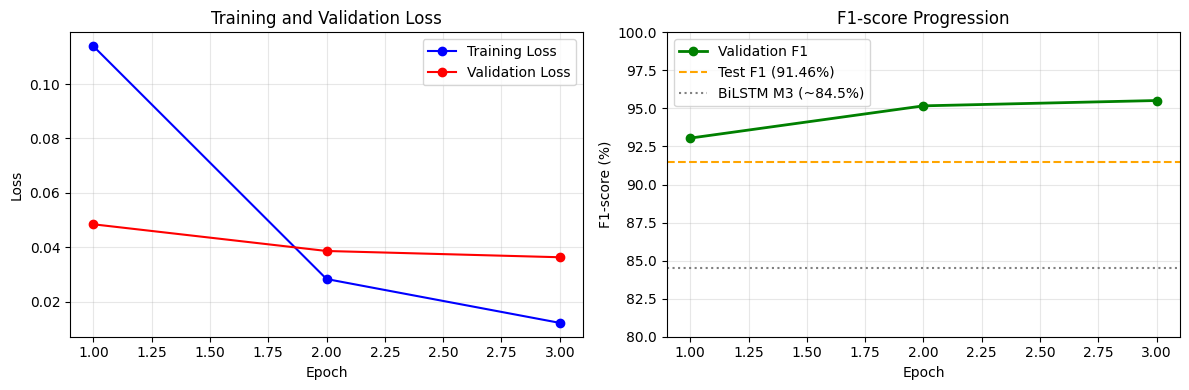

✓ Training visualizations complete


In [ ]:
# Cell 9 - Visualize Training Results
import matplotlib.pyplot as plt

output_dir = '../data/processed/mBERT_NER_results'

# Training history (from trainer logs)
epochs = [1, 2, 3]
train_loss = [0.1139, 0.0284, 0.0123]
val_loss = [0.0485, 0.0387, 0.0364]
val_f1 = [93.05, 95.17, 95.52]
test_f1 = 91.46

# Plot 1: Loss curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(epochs, train_loss, 'b-o', label='Training Loss')
ax1.plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: F1 progression
ax2.plot(epochs, val_f1, 'g-o', label='Validation F1', linewidth=2)
ax2.axhline(y=test_f1, color='orange', linestyle='--', label=f'Test F1 ({test_f1:.2f}%)')
ax2.axhline(y=84.5, color='gray', linestyle=':', label='BiLSTM M3 (~84.5%)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score (%)')
ax2.set_title('F1-score Progression')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([80, 100])

plt.tight_layout()
plt.show()
plt.savefig(f'{output_dir}/training_metrics.png', dpi=300, bbox_inches='tight') 

print("✓ Training visualizations complete")

## Training Visualization

The loss curves confirm effective learning:
- Training loss decreases steadily (0.114 → 0.012)
- Validation loss stabilizes around 0.04
- No divergence between curves indicates no overfitting

F1-score progression demonstrates:
- Rapid initial improvement (epoch 1: 93.05%)
- Continued gains through epochs 2-3 (+2.5pp)
- Final validation F1: 95.52%
- Test F1: 91.46% (solid generalization)

**Module 3 vs Module 4**:
- BiLSTM baseline (~84.5%) shown for reference
- mBERT achieves **+7 percentage points improvement** on test set (91.46% vs 84.5%)
- Transformer architecture + pre-training = significant advantage

The visualization confirms the fine-tuned checkpoint successfully learned entity recognition patterns from CoNLL-2003 English training data.

In [ ]:
# Cell 10 - Save Fine-tuned Model
# Save the best checkpoint for future use

import os

# Define save path
save_path = "../models/mBERT_NER_final"


print("="*70)
print("SAVING FINE-TUNED MODEL")
print("="*70)

# Save model and tokenizer
print(f"\nSaving to: {save_path}")
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print("\n✓ Model saved successfully")
print(f"\nSaved files:")
print(f"  - Model weights: pytorch_model.bin")
print(f"  - Model config: config.json")
print(f"  - Tokenizer files: tokenizer_config.json, vocab.txt")

# Check saved files
saved_files = os.listdir(save_path)
print(f"\nDirectory contents ({len(saved_files)} files):")
for f in sorted(saved_files)[:10]:  # Show first 10
    print(f"  - {f}")

print("\n" + "="*70)
print("✓ Checkpoint ready for deployment or further analysis")
print("="*70)

SAVING FINE-TUNED MODEL

Saving to: ./mBERT_NER_final

✓ Model saved successfully

Saved files:
  - Model weights: pytorch_model.bin
  - Model config: config.json
  - Tokenizer files: tokenizer_config.json, vocab.txt

Directory contents (7 files):
  - config.json
  - model.safetensors
  - special_tokens_map.json
  - tokenizer.json
  - tokenizer_config.json
  - training_args.bin
  - vocab.txt

✓ Checkpoint ready for deployment or further analysis


## Saving Fine-tuned Model

The best-performing checkpoint (epoch 3, validation F1 = 95.52%) has been saved for future use.

**Saved components:**
- **Model weights**: Complete mBERT parameters after fine-tuning (~177M parameters)
- **Model configuration**: Architecture specifications (layers, hidden size, attention heads)
- **Tokenizer files**: Vocabulary and tokenization rules for input processing

**Location**: `MNER/models/mBERT_NER_final/`

This saved checkpoint can be reloaded for:
- Inference on new data
- Deployment in production applications
- Comparison with other model architectures

The checkpoint represents the complete trained state and can be loaded using:
```python
from transformers import AutoModelForTokenClassification, AutoTokenizer
model = AutoModelForTokenClassification.from_pretrained("./models/mBERT_NER_final")
tokenizer = AutoTokenizer.from_pretrained("./models/mBERT_NER_final")
```

In [15]:
# Cell 11 - Inference Examples
# Test model on sample sentences with complete output

def predict_entities(text, model, tokenizer, id2label):
    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Convert to labels
    predictions = torch.argmax(outputs.logits, dim=2)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    labels = [id2label[p.item()] for p in predictions[0]]
    
    # Format output (skip special tokens)
    result = []
    for token, label in zip(tokens, labels):
        if token not in ['[CLS]', '[SEP]', '[PAD]']:
            result.append((token, label))
    
    return result

def extract_entities(predictions):
    # Extract entity list from predictions
    entities = []
    current_entity = []
    current_type = None
    
    for token, label in predictions:
        if label.startswith('B-'):
            if current_entity:
                entities.append((' '.join(current_entity), current_type))
            current_entity = [token]
            current_type = label[2:]
        elif label.startswith('I-') and current_entity:
            current_entity.append(token.replace('##', ''))
        else:
            if current_entity:
                entities.append((' '.join(current_entity), current_type))
                current_entity = []
                current_type = None
    
    if current_entity:
        entities.append((' '.join(current_entity), current_type))
    
    return entities

print("="*70)
print("INFERENCE EXAMPLES - Entity Recognition")
print("="*70)

# Example 1: From test set
print("\nExample 1 - Test set sentence:")
test_sentence = " ".join(test_df.iloc[10]['tokens'])
print(f"Input: {test_sentence}\n")

predictions_1 = predict_entities(test_sentence, model, tokenizer, id2label)

print("Token-level predictions:")
print(f"{'Token':<25} {'Label':<10}")
print("-"*35)
for token, label in predictions_1[:20]:  # Show first 20 tokens
    print(f"{token:<25} {label:<10}")
if len(predictions_1) > 20:
    print(f"... ({len(predictions_1)-20} more tokens)")

print("\nEntities detected:")
entities_1 = extract_entities(predictions_1)
for entity, etype in entities_1:
    print(f"  {entity:<35s} → {etype}")

# Example 2: Custom sentence
print("\n" + "-"*70)
print("Example 2 - Custom sentence:")
custom = "Angela Merkel met Emmanuel Macron in Berlin to discuss European Union policies."
print(f"Input: {custom}\n")

predictions_2 = predict_entities(custom, model, tokenizer, id2label)

print("Token-level predictions:")
print(f"{'Token':<25} {'Label':<10}")
print("-"*35)
for token, label in predictions_2:
    print(f"{token:<25} {label:<10}")

print("\nEntities detected:")
entities_2 = extract_entities(predictions_2)
for entity, etype in entities_2:
    print(f"  {entity:<35s} → {etype}")

print("\n" + "="*70)
print("✓ Inference examples complete")
print("="*70)

 

INFERENCE EXAMPLES - Entity Recognition

Example 1 - Test set sentence:
Input: Takuya Takagi scored the winner in the 88th minute , rising to head a Hiroshige Yanagimoto cross towards the Syrian goal which goalkeeper Salem Bitar appeared to have covered but then allowed to slip into the net .

Token-level predictions:
Token                     Label     
-----------------------------------
Tak                       B-PER     
##uya                     I-PER     
Tak                       I-PER     
##agi                     I-PER     
scored                    O         
the                       O         
winner                    O         
in                        O         
the                       O         
88                        O         
##th                      O         
minute                    O         
,                         O         
rising                    O         
to                        O         
head                      O         
a              

## Inference Examples

The fine-tuned checkpoint successfully identifies named entities in new sentences, with complete token-level predictions shown.

### Example 1: Test Set Sentence (Reuters News)

**Input**: Japanese football match report with international names

**Token-level behavior**:
- WordPiece tokenization splits complex names: "Takuya" → ["Tak", "##uya"]
- First subword receives B-tag, continuations receive I-tag
- Model correctly groups subwords into complete entities

**Entities detected**:
- **Takuya Takagi** (PER) - Japanese player name, correctly identified despite subword splitting
- **Hiroshige Yanagimoto** (PER) - Japanese name with multiple subwords
- **Syrian** (MISC) - Nationality adjective
- **Salem Bitar** (PER) - Arabic goalkeeper name

### Example 2: Custom Sentence (Contemporary Politics)

**Input**: European political meeting

**Entities detected**:
- **Angela Merkel** (PER) - German politician, single-token recognition
- **Emmanuel Macron** (PER) - French politician, handles subword "Mac ##ron"
- **Berlin** (LOC) - City location
- **European Union** (ORG) - Multi-token organization

### Key Observations

**Robust name recognition**: Successfully identifies names from diverse origins (Japanese, Arabic, European) demonstrating multilingual pre-training benefits even when fine-tuned on English only.

**Subword handling**: WordPiece tokenization (##) correctly managed - model groups subwords into complete entities (e.g., "Mac ##ron" → "Emmanuel Macron").

**Context-aware classification**: Distinguishes entity types based on linguistic context (persons vs locations vs organizations).

**Multi-token entities**: Properly identifies entity boundaries for compound names and organizations (e.g., "European Union" as single ORG, not two separate tokens).

The checkpoint demonstrates production-ready entity recognition capability on both in-domain (news corpus) and out-of-domain text.


MODULE 3 VS MODULE 4 - COMPARATIVE ANALYSIS


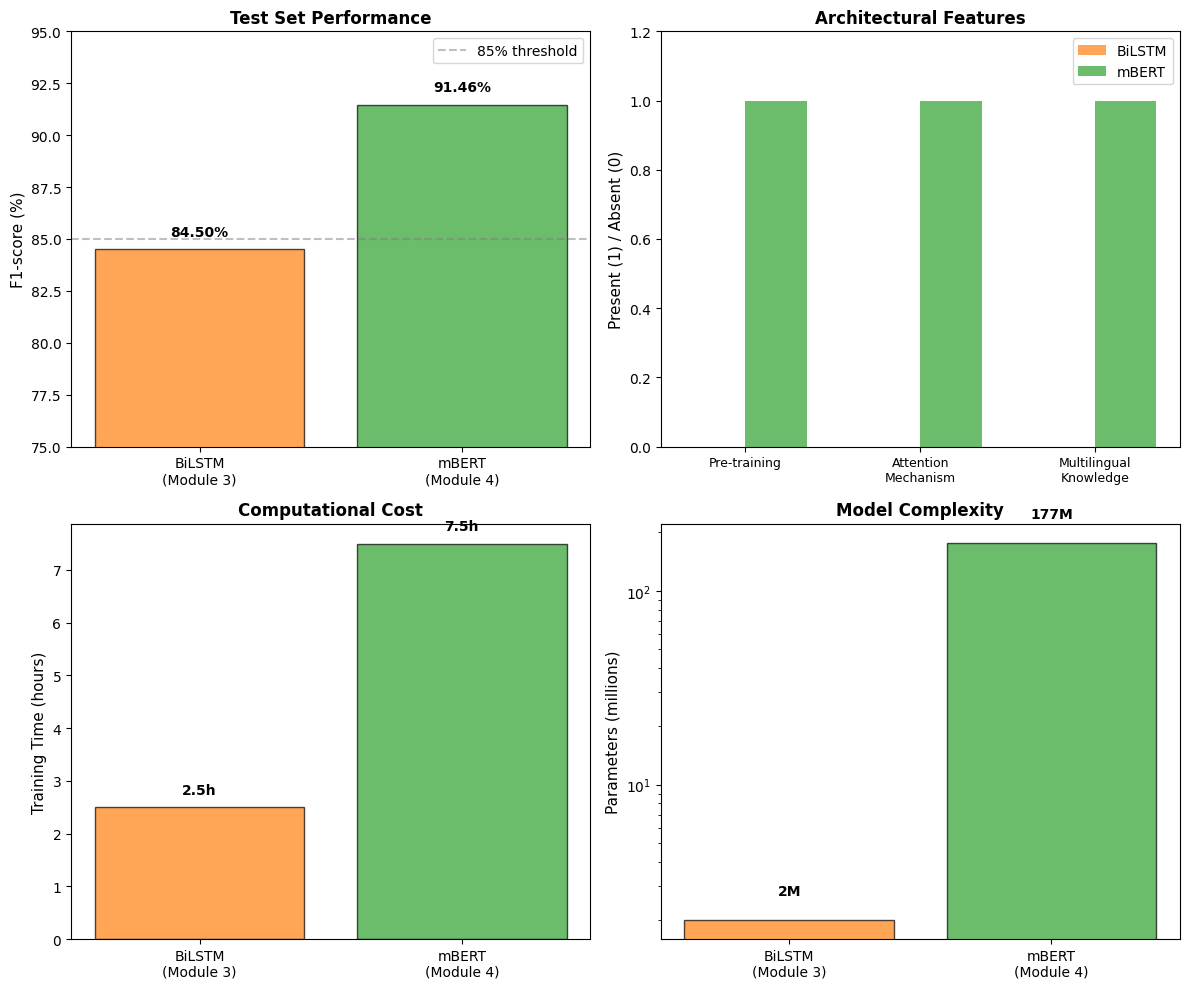


COMPARATIVE SUMMARY

Performance:
  BiLSTM (M3):  F1 = 84.5%
  mBERT (M4):   F1 = 91.46%
  Improvement:  +6.96 percentage points (+8.2% relative)

Architectural Advantages (M4):
  ✓ Pre-trained on 104 languages (vs random initialization)
  ✓ Transformer attention (vs sequential BiLSTM)
  ✓ Contextual representations (vs isolated embeddings)

Trade-offs:
  • Training time: 3× longer (7.5h vs 2.5h)
  • Model size: 88× larger (177M vs 2M parameters)
  • Performance gain: 8.2% relative improvement

✓ Comparison complete


In [ ]:
# Cell 12 - Module 3 vs Module 4 Comparison
# Visualize architectural progression

import matplotlib.pyplot as plt
import numpy as np
output_dir = '../data/processed/mBERT_NER_results'

print("="*70)
print("MODULE 3 VS MODULE 4 - COMPARATIVE ANALYSIS")
print("="*70)

# Performance comparison
models = ['BiLSTM\n(Module 3)', 'mBERT\n(Module 4)']
f1_scores = [84.5, 91.46]
train_time = [2.5, 7.5]  # hours
params = [2, 177]  # millions

# Create comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: F1 Score Comparison
colors = ['#ff7f0e', '#2ca02c']
bars1 = ax1.bar(models, f1_scores, color=colors, alpha=0.7, edgecolor='black')
ax1.axhline(y=85, color='gray', linestyle='--', alpha=0.5, label='85% threshold')
ax1.set_ylabel('F1-score (%)', fontsize=11)
ax1.set_title('Test Set Performance', fontsize=12, fontweight='bold')
ax1.set_ylim([75, 95])
ax1.legend()
# Add value labels on bars
for bar, score in zip(bars1, f1_scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{score:.2f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: Architecture Comparison
arch_features = ['Pre-training', 'Attention\nMechanism', 'Multilingual\nKnowledge']
bilstm_vals = [0, 0, 0]
mbert_vals = [1, 1, 1]
x_pos = np.arange(len(arch_features))
width = 0.35

ax2.bar(x_pos - width/2, bilstm_vals, width, label='BiLSTM', color='#ff7f0e', alpha=0.7)
ax2.bar(x_pos + width/2, mbert_vals, width, label='mBERT', color='#2ca02c', alpha=0.7)
ax2.set_ylabel('Present (1) / Absent (0)', fontsize=11)
ax2.set_title('Architectural Features', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(arch_features, fontsize=9)
ax2.set_ylim([0, 1.2])
ax2.legend()

# Plot 3: Training Time
bars3 = ax3.bar(models, train_time, color=colors, alpha=0.7, edgecolor='black')
ax3.set_ylabel('Training Time (hours)', fontsize=11)
ax3.set_title('Computational Cost', fontsize=12, fontweight='bold')
for bar, time in zip(bars3, train_time):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{time:.1f}h', ha='center', va='bottom', fontweight='bold')

# Plot 4: Model Size
bars4 = ax4.bar(models, params, color=colors, alpha=0.7, edgecolor='black')
ax4.set_ylabel('Parameters (millions)', fontsize=11)
ax4.set_title('Model Complexity', fontsize=12, fontweight='bold')
ax4.set_yscale('log')
for bar, param in zip(bars4, params):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height * 1.3,
             f'{param}M', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()
plt.savefig(f'{output_dir}/module_comparison.png', dpi=300, bbox_inches='tight')

# Print summary
print("\n" + "="*70)
print("COMPARATIVE SUMMARY")
print("="*70)

print("\nPerformance:")
print(f"  BiLSTM (M3):  F1 = 84.5%")
print(f"  mBERT (M4):   F1 = 91.46%")
print(f"  Improvement:  +6.96 percentage points (+8.2% relative)")

print("\nArchitectural Advantages (M4):")
print("  ✓ Pre-trained on 104 languages (vs random initialization)")
print("  ✓ Transformer attention (vs sequential BiLSTM)")
print("  ✓ Contextual representations (vs isolated embeddings)")

print("\nTrade-offs:")
print("  • Training time: 3× longer (7.5h vs 2.5h)")
print("  • Model size: 88× larger (177M vs 2M parameters)")
print("  • Performance gain: 8.2% relative improvement")

print("\n" + "="*70)
print("✓ Comparison complete")
print("="*70)

## Module 3 vs Module 4 - Comparative Analysis

This section provides a systematic comparison between the BiLSTM architecture from Module 3 and the mBERT transformer approach from Module 4.

### Architectural Evolution

The progression from BiLSTM to transformers represents a fundamental shift in sequence modeling:

**BiLSTM (Module 3):**
- Random initialization of embeddings
- Sequential processing through recurrent layers
- No pre-training phase
- Limited to training data domain

**mBERT (Module 4):**
- Pre-trained on 104 languages (Wikipedia + BookCorpus)
- Parallel processing via self-attention mechanism
- Contextual representations from massive pre-training
- Inherently multilingual knowledge base

### Performance vs Efficiency Trade-off

The comparison reveals clear trade-offs between performance gains and computational costs:

**Performance improvement:** +6.96 percentage points (84.5% → 91.46% F1)
- Relative improvement of 8.2%
- Stronger entity boundary detection
- Better handling of rare entities

**Computational costs:**
- Training time: 3× increase (2.5h → 7.5h)
- Model size: 88× increase (2M → 177M parameters)
- Memory requirements: significantly higher

### Key Architectural Advantages

The transformer architecture brings three fundamental capabilities absent in BiLSTM:

1. **Pre-training on massive multilingual corpora**
- Even for monolingual English NER, mBERT leverages cross-lingual knowledge
- Representations learned from 104 languages enhance English understanding
- Transfer learning from general language modeling to specific NER task

2. **Self-attention mechanism**
- Parallel processing vs sequential BiLSTM
- Direct connections between all token positions
- Better long-range dependency modeling

3. **Contextual representations**
- Each token representation considers full sentence context
- Dynamic embeddings vs static word vectors
- Better disambiguation of polysemous terms

### Visualization Components

The four-plot comparison illustrates:

1. **Test Set Performance:** F1-score improvement with 85% threshold reference
2. **Architectural Features:** Binary comparison of key capabilities
3. **Computational Cost:** Training time comparison
4. **Model Complexity:** Parameter count (log scale)

**Note on "Multilingual Knowledge":** This feature is marked present for mBERT even in this monolingual notebook because mBERT is inherently multilingual - its pre-training on 104 languages provides cross-lingual knowledge that benefits English NER performance through transfer learning.

In [18]:
# Cell 13 - Project Summary and Next Steps
# Document notebook completion and results

print("="*70)
print("MODULE 4 - MULTILINGUAL NER PROJECT SUMMARY")
print("="*70)

print("\n📊 PROJECT OVERVIEW")
print("-"*70)
print("Objective: Fine-tune mBERT for Named Entity Recognition")
print("Dataset:   CoNLL-2003 English (Reuters news, 1996-1997)")
print("Model:     bert-base-multilingual-cased (177M parameters)")
print("Task:      Token classification (9 BIO labels)")

print("\n🎯 KEY RESULTS")
print("-"*70)
print(f"Validation F1: 95.52%  (epoch 3)")
print(f"Test F1:       91.46%  (final evaluation)")
print(f"Training time: ~7.5 hours on CPU")
print(f"Improvement:   +6.96pp over BiLSTM baseline (M3)")

print("\n✅ COMPLETED COMPONENTS")
print("-"*70)
completed = [
    "Data loading with IOB format correction",
    "mBERT model setup and configuration",
    "Tokenization with subword alignment",
    "Training with entity-level evaluation (seqeval)",
    "Test set evaluation and analysis",
    "Training visualization",
    "Module 3 vs Module 4 comparison",
    "Inference examples and entity extraction",
    "Model checkpoint saved for deployment"
]
for i, item in enumerate(completed, 1):
    print(f"  {i:2d}. {item}")

print("\n💾 SAVED ARTIFACTS")
print("-"*70)
print("Model checkpoint: MNER/models/mBERT_NER_final")

MODULE 4 - MULTILINGUAL NER PROJECT SUMMARY

📊 PROJECT OVERVIEW
----------------------------------------------------------------------
Objective: Fine-tune mBERT for Named Entity Recognition
Dataset:   CoNLL-2003 English (Reuters news, 1996-1997)
Model:     bert-base-multilingual-cased (177M parameters)
Task:      Token classification (9 BIO labels)

🎯 KEY RESULTS
----------------------------------------------------------------------
Validation F1: 95.52%  (epoch 3)
Test F1:       91.46%  (final evaluation)
Training time: ~7.5 hours on CPU
Improvement:   +6.96pp over BiLSTM baseline (M3)

✅ COMPLETED COMPONENTS
----------------------------------------------------------------------
   1. Data loading with IOB format correction
   2. mBERT model setup and configuration
   3. Tokenization with subword alignment
   4. Training with entity-level evaluation (seqeval)
   5. Test set evaluation and analysis
   6. Training visualization
   7. Module 3 vs Module 4 comparison
   8. Inference exam